In [4]:
import os, glob, sys
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/skim/data/

env: CITYSCAPES_DATASET=/home/skim/data/


In [3]:
#run this cell once
%run  cityscapesscripts/preparation/createTrainIdInstanceImgs
%run  cityscapesscripts/preparation/createTrainIdInstanceImgs

/home/rvygon/data/gtFine/*/*/*_gt*_polygons.json
Processing 5000 annotation files
Progress: 0.0 % Failed to convert: /home/rvygon/data/gtFine/test/berlin/berlin_000000_000019_gtFine_polygons.json


PermissionError: [Errno 13] Permission denied: '/home/rvygon/data/gtFine/test/berlin/berlin_000000_000019_gtFine_instanceTrainIds.png'

/home/rvygon/data/gtFine/*/*/*_gt*_polygons.json
Processing 5000 annotation files
Progress: 0.0 % Failed to convert: /home/rvygon/data/gtFine/test/berlin/berlin_000000_000019_gtFine_polygons.json


PermissionError: [Errno 13] Permission denied: '/home/rvygon/data/gtFine/test/berlin/berlin_000000_000019_gtFine_instanceTrainIds.png'

In [24]:
x_val, y_val,files = importBatch(200,200,0,'val',scale = 4)
from keras.utils import to_categorical
y_val[y_val==255]=19
y_val = to_categorical(y_val)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_pic(X, y):
    y[y==255]=19
    y=to_categorical(y)
    return X, y

def keras_generator(batch_size,scale):
    while True:
        batch_nums = np.random.randint(low=1000, high=2000, size=batch_size)
        batch_input = []
        batch_output = []
        
        for index in batch_nums:
            input_labels, input_images = getData(1, index,type='train')
            input_image = input_images[0]
            input_label = input_labels[0]           
            
            X_img = imread(input_image)
            if (scale != 0):
                X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
                k = 0
                for x in X_img[::scale]:
                    X_new[k]=x[::scale]
                    k+=1
                X_img = X_new
            y_img = imread(input_label)
            if (scale != 0):
                y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
                k = 0
                for y in y_img[::scale]:
                    y_new[k] = y[::scale]
                    k += 1
                y_img = y_new
            
            X_img, y_img = preprocess_pic(X_img, y_img)
            
            batch_input.append(X_img)
            batch_output.append(y_img)
            
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)        
        yield batch_x, batch_y
        

In [8]:
#UNET https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights = None,input_size = (256,512,3)):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [25]:
model =  load_model('unet_RV.hdf5')
generator = keras_generator(1)
model_checkpoint = ModelCheckpoint('unet_RV.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(generator,steps_per_epoch=1500,epochs=8,callbacks=[model_checkpoint], validation_data=(x_val,y_val),validation_steps=20)

Epoch 1/8
1500/1500 [==============================] - 258s 172ms/step - loss: 0.8239 - acc: 0.7466 - val_loss: 0.9341 - val_acc: 0.7168

Epoch 00001: loss improved from inf to 0.82394, saving model to unet_RV.hdf5
Epoch 2/8
  46/1500 [..............................] - ETA: 3:06 - loss: 0.8263 - acc: 0.7549

KeyboardInterrupt: 

In [4]:
new_model = load_model('unet_RV.hdf5')
#new_model.summary()
model = new_model


200/200 [==============================] - 9s 45ms/step
(256, 512, 20)


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


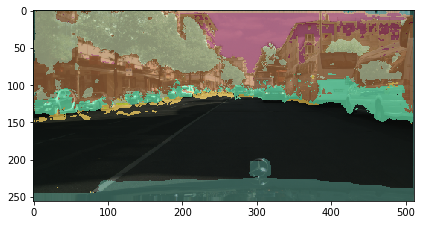

In [27]:
results = new_model.predict(x_val,verbose=1)
print(results[1].shape)
#res_image=np.argmax(results[0], axis=2)
colorImage1(x_val[1], results[1], 'classes.txt')

In [5]:
x_pred=model.predict(x_val,verbose=1)
x_pred = np.argmax(x_pred,axis=3)
x_pred.shape

NameError: name 'x_val' is not defined

In [36]:
x_up = UpscaleImg(x_pred[0], 4)
x_up.shape

NameError: name 'UpscaleImg' is not defined

In [17]:
def eval_model(model):    
        cityscapesPath = os.environ['CITYSCAPES_DATASET']
        x_val, y_val, filenames = importBatch(1000,0,0,'val',4)
        x_pred = model.predict(x_val,verbose=1)
        for i in range(x_pred.shape[0]):
            imsave(os.path.join(cityscapesPath,'results', filenames[i]), x_pred[i])
        %run cityscapesscripts/evaluation/evalPixelLevelSemanticLabeling
eval_model(new_model)
        

    
    

500/500 [==============================] - 18s 37ms/step


ValueError: Invalid number of channels in image array.